In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import os
import yaml
import cmocean.cm as cmo
import pandas as pd
import numpy as np
import datetime
from scipy.signal import find_peaks
from tqdm.notebook import tqdm
import time
import concurrent.futures
import netCDF4 as nc

import gsw
import glidertools as gt
from scipy.signal import find_peaks

def mixed_layer(pwp_out_, thre, rdp, pwp):
    if pwp=='pwp':
        pres= pwp_out_['z']
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['potential_density'].flatten(), ref_depth=rdp, thresh=thre)
    elif pwp=='gotm':
        pres= pwp_out_['pressure'].values.T
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['potential_density'].values.T.flatten(), ref_depth=rdp, thresh=thre)

    else:
        pres= pwp_out_['pressure'].values
        XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
        mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['potential_density'].values.flatten(), ref_depth=rdp, thresh=thre)

    return mld

# def barrier_layer(pwp_out_, thre=0.2, rdp=10, pwp=True):
#     if pwp==True:
#         pres= pwp_out_['z']
#         XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
#         mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['cons_temp'].flatten(), ref_depth=rdp, thresh=thre)
#     else:
#         pres= pwp_out_['pressure'].values
#         XX, YY = np.meshgrid(np.arange(0,len(pwp_out_['time']), 1),  pres)
#         mld=gt.physics.mixed_layer_depth(XX.flatten(), YY.flatten(), pwp_out_['cons_temp'].values.flatten(), ref_depth=rdp, thresh=thre)

#     return mld


def n_squa(dff, pwp=True):
    if pwp==True:
        pres= dff['pressure']        
    else:
        pres= dff['pressure'].values
    XX, YY = np.meshgrid(np.arange(0,len(dff['time']), 1),  pres)
    n2=gsw.Nsquared(dff['abs_salinity'].values, dff['cons_temp'].values, YY)[0] 
    return n2

def grid_float(df_glider__,timstep):  
    df_glid_grid=df_glider__.copy()
    df_glid_grid=df_glid_grid.where(np.isfinite(df_glid_grid.mixed_layer_depth)==True, drop=True)

    df_glid_grid=df_glid_grid.rename_vars({'N2':'n2', 'N2_roll':'n2_roll'})
    df_glid_grid['temperature']=gsw.t_from_CT(df_glid_grid.abs_salinity,df_glid_grid.cons_temp,df_glid_grid.pressure)
    df_glid_grid['salinity']=gsw.SP_from_SA(df_glid_grid.abs_salinity,df_glid_grid.pressure,df_glid_grid.longitude, df_glid_grid.latitude)
    # df_glid_grid['barrier_layer']=('time', barrier_layer(df_glid_grid, 0.2, 10, pwp=False))
    time_axis=df_glid_grid.time.values
    yaxis_g=df_glid_grid.pressure.values
    df_glid_grid['mixed_layer_depth']=('time', mixed_layer(df_glid_grid, 0.125, 2, pwp=False))

    return df_glid_grid



def _get_bottom_top_mode_water_glider(float_):
    yaxis=float_.pressure.values
    NN=np.min(np.diff(float_.pressure))
    
    float_['dens_baseml']=float_.sel(pressure=float_.mixed_layer_depth.ffill('time').bfill('time')).potential_density
    if (float_.latitude.mean().values>20) == True:
        dist_to_find_peaks=2*pd.to_timedelta('150d')/(pd.to_timedelta(float_.time.diff('time'))[0])
        rol_dens=float_['dens_baseml'].rolling(time=1, center=True).median()
        peaks, _ = find_peaks(rol_dens, distance=dist_to_find_peaks) #distance=20)

    else: 
        dist_to_find_peaks=pd.to_timedelta('150d')/(pd.to_timedelta(float_.time.diff('time'))[0])
        rol_dens=float_['dens_baseml'].rolling(time=1, center=True).median()
        peaks, _ = find_peaks(rol_dens, distance=dist_to_find_peaks) #distance=20)


    DEN_ARR=np.arange(len(float_.time))*0.0
    peaks=np.concatenate([[0], peaks])
    DEN_ARR[peaks]=rol_dens[peaks]

    float_['density_MW']=('time', DEN_ARR)
    float_['density_MW'][DEN_ARR==0]=np.nan
    float_['density_MW']=float_['density_MW'].ffill('time')

    float_['mwd']=('time',(np.ma.masked_invalid(np.abs(float_['potential_density']-float_['density_MW']))[:].argmin(axis=0))*NN)
    float_['mwd']=float_['mwd'].astype(float)
    float_['mwd'][float_['mwd']==0]=np.nan
    float_['mwd'][float_['mwd'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['mwd'].values<float_['mixed_layer_depth'].values]
    float_['mixed_layer_depth'][float_['mixed_layer_depth']==0]=np.nan

    minn2_depth, bot_array, top_array=[],[],[]

    vmini, vmaxi=0, len(float_.time)
    for N in tqdm(range(vmini,vmaxi)):
        if ((np.isfinite(float_.mixed_layer_depth[N])==False) or (np.isfinite(float_.mwd[N])==False)):
                        minn2_depth.append(np.nan)
                        bot_array.append(np.nan)
                        top_array.append(np.nan)   
        else:
            n2_prof=1/np.abs(float_.n2_roll[int(float_.mixed_layer_depth[N]/NN)+1:int(float_.mwd[N]/NN)-1, N][::-1])
            if len(n2_prof)<1:
                minn2_depth.append(np.nan)
                bot_array.append(np.nan)
                top_array.append(np.nan)   

            else:
                peaks_n2=int(float_.mwd[N]/NN)-NN-np.argmax(n2_prof.values)    

                sig_pfog=float_.potential_density[:, N]
                refdpt=int(peaks_n2)
                # print(refdpt)
                bot_lay=gt.physics.mixed_layer_depth(np.ones(len(yaxis)), yaxis, sig_pfog, thresh=0.05, ref_depth=refdpt*NN)

                siginv=28-sig_pfog[:refdpt][::-1]
                yinv=np.arange(len(siginv))

                top_lay=gt.physics.mixed_layer_depth(np.ones(len(yinv)), yinv, siginv, thresh=0.05, ref_depth=0)  ##### TOP_LAY= (refddpt-13)*2

                bott=bot_lay[1]
                topp=(refdpt-top_lay[1])*NN

                minn2_depth.append(refdpt*NN)
                bot_array.append(bott)
                top_array.append(topp)

    float_['top_mwl']=('time', np.array(top_array))
    float_['bot_mwl']=('time', np.array(bot_array))    
    float_['min_n2_depth']=('time', np.array(minn2_depth))        
    float_['top_mwl'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]
    
    return float_

def era_to_PWP(ds_era):
    era5_=ds_era.rename_vars({'mslhf':'qlat', 'msnswrf':'sw', 'msnlwrf':'lw', 'msshf':'qsens'})
    def tau_(speed_u, speed_v):
        U=(speed_u**2+speed_v**2)**(0.5)
        Cd = 0.001
        rho_air=1.225
        tau=rho_air*Cd*speed_u*U
        return tau
    era5_['tx']=tau_(era5_['u10'], era5_['v10'])
    era5_['ty']=tau_(era5_['v10'], era5_['u10'])
    era5_['precip']= era5_.mtpr/1000  #kg m**-2 s**-1 / 1000 kgm-3 --> m/s
    era5_['evap']= era5_.mer/1000
    era5_=era5_.drop_vars(['sst', 'mer', 'mtpr'])
    return era5_


def center_properties(dff,variablee):
    dff['core_'+variablee]=dff[variablee].sel(pressure=dff.min_n2_depth.fillna(dff.pressure[0]))*((dff.min_n2_depth/dff.min_n2_depth))

def get_time_formation(df_arg):
    lol=df_arg['density_MW'].fillna(0).diff('time')
    lol2=lol.where(np.abs(lol) > 0, drop=True)
    times=lol2['time'].values
    return times

def check_threshold_and_following_pointsMAX(series, threshold):
    validityrange=10
    passed_threshold_index = None
    # Iterate through the time series data
    for i in range(len(series)):
        if series[i] > threshold:
            # Check if the last 5 points after passing the threshold remain above it
            if all(value >= threshold for value in series[i:i+validityrange]):
                passed_threshold_index = i
                break  # Stop iteration once the condition is met

    return passed_threshold_index

def check_threshold_and_following_pointsMIN(series, threshold): #8*4, 2
    validityrange=10
    passed_threshold_index = None
    # Iterate through the time series data
    for i in range(len(series)):
        if series[i] < threshold:
            # Check if the last 5 points after passing the threshold remain above it
            if all(value <= threshold for value in series[i:i+validityrange]):
                passed_threshold_index = i
                break  # Stop iteration once the condition is met

    return passed_threshold_index

def get_time_formation_min_and_erosion(df_arg):
    ind_st=[[df_arg['time'][0].values,df_arg['time'][0].values, df_arg['time'][0].values]]
    if len(get_time_formation(df_arg))<1:
        ind_st=[[df_arg['time'][0].values,df_arg['time'][0].values, df_arg['time'][0].values]]

    elif len(get_time_formation(df_arg))<2:
        dff=df_arg['core_n2'].rolling(time=1, center=True).median().ffill('time').sel(time=slice(get_time_formation(df_arg)[0],df_arg['time'][-1] )).bfill('time')                 
        
        index_min=check_threshold_and_following_pointsMIN(dff, 0.00005)
        if index_min==None:
            index_min=0
            # index_max=0
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)+index_min
            
        else: 
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)+index_min

            ind_st=[[get_time_formation(df_arg)[0], dff.time[index_min].values, dff.time[index_max].values]]
        
    else:
        ind_st=[]
        for inddst in range(len(get_time_formation(df_arg))-1):
            dff=df_arg['core_n2'].rolling(time=1, center=True).median().ffill('time').sel(time=slice(get_time_formation(df_arg)[inddst], get_time_formation(df_arg)[inddst+1])).bfill('time')             

            index_min=check_threshold_and_following_pointsMIN(dff, 0.00005)
            # print(index_min)
            if index_min==None:
                index_min=0
                # index_max=0
                if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)==None:
                    index_max=index_min
                else:
                    index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)+index_min
                
            else: 
                if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)==None:
                    index_max=index_min
                else:
                    index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)+index_min

            ind_st.append([get_time_formation(df_arg)[inddst], dff.time[index_min].values, dff.time[index_max].values])
            
            
        inddst=len(get_time_formation(df_arg))-1
        dff=df_arg['core_n2'].rolling(time=1, center=True).median().ffill('time').sel(time=slice(get_time_formation(df_arg)[inddst], df_arg['time'][-1] )).bfill('time')                
        
        index_min=check_threshold_and_following_pointsMIN(dff, 0.00005)
        if index_min==None:
            index_min=0
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)+index_min
        else: 
            if check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)==None:
                index_max=index_min
            else:
                index_max=check_threshold_and_following_pointsMAX(dff[index_min:], 0.00005)+index_min
        ind_st.append([get_time_formation(df_arg)[inddst], dff.time[index_min].values, dff.time[index_max].values])
            
    return ind_st

def _set_presence_mwl(df_plot_):
    center_properties(df_plot_, 'n2')
    ## pwp 
    msk = df_plot_.mixed_layer_depth.isnull().values.astype(float)
    msk[msk==1]=np.nan
    msk[msk==0]=1

    df_plot_['presence_mwl']=df_plot_.min_n2_depth.copy()*np.nan
    dss=pd.DataFrame(get_time_formation_min_and_erosion(df_plot_))
    df_plot_['presence_mwl'].loc[dict(time=dss[0].to_numpy())]=0 # formation
    df_plot_['presence_mwl'].loc[dict(time=dss[1].to_numpy())]=1  # min
    df_plot_['presence_mwl'].loc[dict(time=dss[2].to_numpy())]=2 # erosiom
    df_plot_['presence_mwl']=df_plot_['presence_mwl'].ffill('time')
    df_plot_['presence_mwl']= df_plot_['presence_mwl']*msk

    return df_plot_

def _get_bottom_top_mode_water_3d(float_):
    yaxis=float_.pressure.values
    if np.count_nonzero(~np.isnan(float_.cons_temp.values))==0:
        nan_arr=np.ones(len(float_.time))*np.nan
        float_['density_MW']=('time', nan_arr)
        float_['mwd']=('time', nan_arr)
        float_['dens_baseml']=('time', nan_arr)
        float_['top_mwl']=('time',nan_arr)
        float_['bot_mwl']=('time', nan_arr)    
        float_['min_n2_depth']=('time',nan_arr)        
        float_['presence_mwl']=('time',nan_arr)        
    
    else:
        float_['dens_baseml']=float_.sel(pressure=float_.mixed_layer_depth.ffill('time').bfill('time')).potential_density
        if (float_.latitude.mean().values>20) == True:
            dist_to_find_peaks=2*pd.to_timedelta('150d')/(pd.to_timedelta(float_.time.diff('time'))[0])
            rol_dens=float_['dens_baseml'].rolling(time=1, center=True).median()
            peaks, _ = find_peaks(rol_dens, distance=dist_to_find_peaks) #distance=20)

        else: 
            dist_to_find_peaks=pd.to_timedelta('150d')/(pd.to_timedelta(float_.time.diff('time'))[0])
            rol_dens=float_['dens_baseml'].rolling(time=1, center=True).median()
            peaks, _ = find_peaks(rol_dens, distance=dist_to_find_peaks) #distance=20)


        DEN_ARR=np.arange(len(float_.time))*0.0
        peaks=np.concatenate([[0], peaks])
        DEN_ARR[peaks]=rol_dens[peaks]

        float_['density_MW']=('time', DEN_ARR)
        float_['density_MW'][DEN_ARR==0]=np.nan
        float_['density_MW']=float_['density_MW'].ffill('time')


        float_['mwd']=('time',float_.pressure.values[np.ma.masked_invalid(np.abs(float_['potential_density']-float_['density_MW']))[:].argmin(axis=1)]) ## changed axis & way to get the depht
        float_['mwd']=float_['mwd'].astype(float)
        float_['mwd'][float_['mwd']==0]=np.nan
        float_['mwd'][float_['mwd'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['mwd'].values<float_['mixed_layer_depth'].values]
        float_['mixed_layer_depth'][float_['mixed_layer_depth']==0]=np.nan

        minn2_depth, bot_array, top_array=[],[],[]

        vmini, vmaxi=0, len(float_.time)
        for N in range(vmini,vmaxi):
            if ((np.isfinite(float_.mixed_layer_depth[N])==False) or (np.isfinite(float_.mwd[N])==False)):
                minn2_depth.append(np.nan)
                bot_array.append(np.nan)
                top_array.append(np.nan)   
            else:
                n2_prof=1/np.abs(float_.n2[N, np.argwhere(float_.pressure.values==float_.mixed_layer_depth[N].item()).item()+1:np.argwhere(float_.pressure.values==float_.mwd[N].item()).item()-1][::-1]) ## no roll for mdoel
                if len(n2_prof)<1:
                    minn2_depth.append(np.nan)
                    bot_array.append(np.nan)
                    top_array.append(np.nan)   

                else:
                    peaks_n2=np.argwhere(float_.pressure.values==float_.mwd[N].item()).item()-1-np.argmax(n2_prof.values)    

                    sig_pfog=float_.potential_density[N, :]
                    refdpt=int(peaks_n2)
                    # print(refdpt)
                    bot_lay=gt.physics.mixed_layer_depth(np.ones(len(yaxis)), yaxis, sig_pfog, thresh=0.05, ref_depth=float_.pressure.values[refdpt])

                    siginv=28-sig_pfog[:refdpt][::-1]
                    yinv=np.arange(len(siginv))

                    top_lay=gt.physics.mixed_layer_depth(np.ones(len(yinv)), yinv, siginv, thresh=0.05, ref_depth=0)  ##### TOP_LAY= (refddpt-13)*2
                    # print(bot_lay, top_lay)

                    bott=bot_lay[1]
                    topp=(float_.pressure.values[refdpt-int(top_lay[1])])

                    minn2_depth.append(float_.pressure.values[refdpt-1])
                    bot_array.append(bott)
                    top_array.append(topp)   
                    # print(N)
        float_['top_mwl']=('time', np.array(top_array))
        float_['bot_mwl']=('time', np.array(bot_array))    
        float_['min_n2_depth']=('time', np.array(minn2_depth))        


        float_['top_mwl'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]=float_['mixed_layer_depth'][float_['top_mwl'].values<float_['mixed_layer_depth'].values]
        float_=_set_presence_mwl(float_)
    return float_


In [2]:
path='/home/jupyter-estelfont/scratch/estel/datasets/ERA5/L0/climatology/'
files= [f for f in os.listdir(path) if f.endswith('.nc')]
files=['/home/jupyter-estelfont/scratch/estel/datasets/ERA5/L0/climatology/'+files[i] for i in range(8)]
df_era= xr.open_mfdataset(files)
ERA5=era_to_PWP(df_era)

df_arg=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/argo_wwl_per_yr/L0/argo_wwl_0_578floats.nc')

# Select float and era5 data to run GOTM

In [3]:
def sel_float_and_era(ind_):
    ds_float=grid_float(df_arg.isel(platform_num=ind_), 1)  #"140", 80, 151900435
    timstep=0
    time_axis=ds_float.time.values
    yaxis_g=ds_float.pressure.values

    float_era5=ERA5.sel(time=slice(time_axis[timstep], time_axis[-1]))   #collocate to lat lon floats
    _lat=ds_float.latitude.mean('pressure').interp_like('time'==float_era5.time).ffill('time')
    _lon=ds_float.longitude.mean('pressure').interp_like('time'==float_era5.time).ffill('time')
    float_era5=float_era5.sel(latitude=_lat, longitude=_lon, method='nearest').drop_vars(['platform_num'])


    for vari in ['cons_temp', 'abs_salinity']:
        ds_float_=ds_float.rolling(pressure=5, center=True).mean().bfill('pressure').ffill('pressure')
        for i in range(len(ds_float.time.groupby('time.year'))):
            tid=ds_float_.time[0]+i*pd.to_timedelta('365d')

            float__ts=ds_float_.sel(time=tid,method='nearest')[[vari, 'pressure']].drop(['time', 'platform_num']).to_dataframe().reset_index()
            float__ts['pressure']=-float__ts['pressure']
            float__ts.columns = range(float__ts.columns.size)
            float__ts=float__ts.rename(columns={0: tid.values.astype('datetime64[s]'), 1: str(len(ds_float.pressure))+' 2'})
            header = pd.DataFrame([float__ts.columns.tolist()], columns=float__ts.columns)
            df = pd.concat([header, float__ts], ignore_index=True)
            df.columns = range(df.columns.size)
            if i==0:
                df1=df.copy()
            if i>0:
                df1=pd.concat([df1, df], axis=0, ignore_index=True)
            if i==  (len(ds_float.time.groupby('time.year'))-1): 
                df1.loc[len(df1.index)] = [0,0] 
                df1[0][len(df1)-1]=ds_float.time[-1].values.astype('datetime64[s]')
                df1[1][len(df1)-1]=df1[1][0]
                df1.to_csv('run_gotm/AS_gotm/input/'+vari+'_initial.dat',sep='\t', header=False, index=False)

    del df, df1
    
    era_ = float_era5.copy()
    era_['Qnet']=era_['qlat']+era_['lw']+era_['qsens']#+era_['sw']
    era_['sw'] = era_['sw'].where(era_['sw'] > 0)
    era_['sw'] = era_['sw'].fillna(0)
    era_heat=era_[['Qnet', 'qlat', 'qsens' ,'lw','sw']].drop(['latitude', 'longitude']).to_dataframe().reset_index()
    era_heat.columns = range(era_heat.columns.size)
    era_heat.to_csv('run_gotm/AS_gotm/input/heat_flux.dat',sep='\t', header=False, index=False)

    era_momentum_flux=era_[['tx', 'ty']]
    era_momentum_flux=era_momentum_flux.drop(['latitude', 'longitude']).to_dataframe().reset_index()
    era_momentum_flux.columns = range(era_momentum_flux.columns.size)
    era_momentum_flux.to_csv('run_gotm/AS_gotm/input/momentum_flux.dat',sep='\t', header=False, index=False)

    era_['precip_']=era_['precip']+era_['evap']
    era_precip=era_['precip_'].drop(['latitude', 'longitude']).to_dataframe().reset_index()
    era_precip.columns = range(era_precip.columns.size)
    era_precip.to_csv('run_gotm/AS_gotm/input/precip_era5.dat',sep='\t', header=False, index=False)

    era_precip=era_[['u10', 'v10', 'sp']]
    era_precip=era_precip.drop(['latitude', 'longitude']).to_dataframe().reset_index()
    era_precip.columns = range(era_precip.columns.size)
    era_precip.to_csv('run_gotm/AS_gotm/input/meteo_era5.dat',sep='\t', header=False, index=False)
    
    del era_heat, era_momentum_flux, era_precip
    
    
    file_path = 'run_gotm/AS_gotm/config_file/AS_template-ii.yaml'
    output_file_path = 'run_gotm/AS_gotm/AS_run.yaml'
    name_of_nun='run_float_'+str(ind_)

    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)

    yaml_content['location']['latitude']=_lat.mean().item()
    yaml_content['location']['longitude']=_lon.mean().item()
    yaml_content['time']['start']=ds_float.time[0].values.astype('datetime64[s]').astype(datetime.datetime)
    yaml_content['time']['stop']=np.nanmin(xr.concat([ds_float.time[-1], era_.time[-1]], dim='time')).astype('datetime64[s]').astype(datetime.datetime) ##era_.time[-4]
    yaml_content['time']['dt']=3600.0
    yaml_content['grid']['nlev']=100
    yaml_content['grid']['ddu']=0
    # yaml_content['light_extinction']['method']= 'jerlov-ia'
    yaml_content['temperature']['relax']['tau']=3600*24*365/2
    yaml_content['salinity']['relax']['tau']=3600*24*365/2

    # yaml_content
    output=yaml_content['output']
    output['run_gotm/AS_gotm/output_L0/'+name_of_nun+'_ii_all'] = output.pop('run_gotm/AS_gotm/output/') #########################################################################

    with open(output_file_path, 'w') as file:
        yaml.dump(yaml_content, file, default_flow_style=False, allow_unicode=True, sort_keys=False)
    
    del era_
    # run! Define the directory containing the .yaml files
    directory = 'run_gotm/AS_gotm'
    command = f"for file in {directory}/*.yaml; do echo Processing \"$file\"; run_gotm/gotm \"$file\" > /dev/null 2>&1; done"
    !{command}
    

    file_path = 'run_gotm/AS_gotm/output_L0/'+name_of_nun+'_ii_all.nc'#########################################################################
    ds = nc.Dataset(file_path, 'r')
    z_axis = ds.variables['z']
    del ds
    
    data = xr.open_dataset(file_path, drop_variables=['zi','z'])
    data['pressure']=('z', -z_axis[0,::].flatten().data)
    data=data.swap_dims({'z':'pressure'})
    data['platform_num_f']=ds_float.platform_num

    for i in ['SS', 'NN', 'NNT', 'NNS']:
        data[i]=(('time', 'pressure', 'lat', 'lon'), data[i].sel(zi=slice(0,len(data.pressure))).values)    

    data=data.sortby('pressure')
    data=data.rename({'temp':'cons_temp', 'salt':'abs_salinity', 'rho_p':'potential_density','NN':'n2','lat':'latitude', 'lon':'longitude'})
    nan_time_var=data.abs_salinity.mean('pressure').copy()*np.nan
    variables_=['density_MW', 'mwd', 'dens_baseml', 'top_mwl', 'bot_mwl', 'min_n2_depth', 'core_n2', 'presence_mwl']
    for i in variables_:
        data[i]=nan_time_var

    data['mixed_layer_depth']=('time', mixed_layer(data.isel(latitude=0, longitude=0).drop_dims('zi'), 0.1, 10, 'gotm'))
    data['potential_density']=data['potential_density']-1000
    
    dlt=_get_bottom_top_mode_water_3d(data.isel(latitude=0, longitude=0))
    
    del data
    
    dlt.to_netcdf('run_gotm/AS_gotm/output_L1/gotm_float_'+str(ind_)+'_ii2.nc')#####x2####################################################################
    print('Float Number: ' + str(ind_))
    # time.sleep(1)

    # print('fl)
    pass

## SHOWCASE FOR 1 FLOAT - 1 GOTM RUN

In [47]:
NN_try=230
sel_float_and_era(NN_try) ## 230

Processing run_gotm/AS_gotm/AS_run.yaml
Float Number: 230


(15325.0, 18718.0)

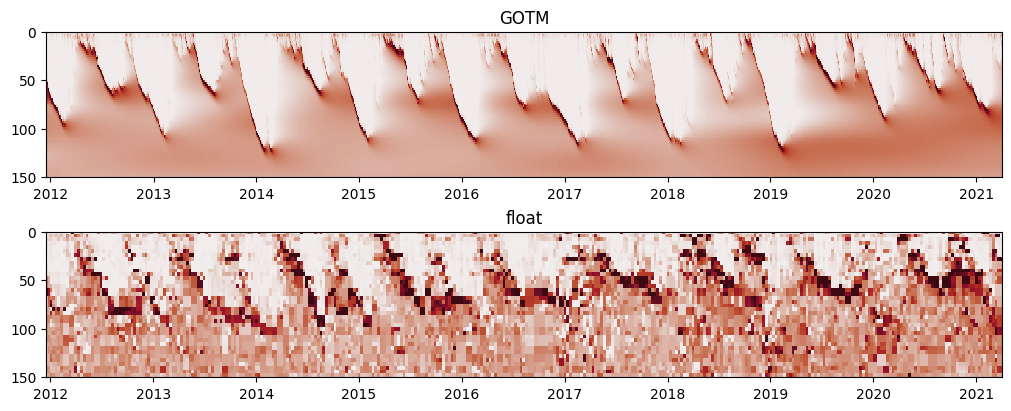

In [51]:
ds_=xr.open_dataset('run_gotm/AS_gotm/output_L1/gotm_float_'+str(NN_try)+'_ii2.nc')

plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(211)
plt.title('GOTM')
plt.pcolormesh(ds_.time, ds_.pressure, ds_.n2.T, vmin=-0.0005, vmax=0.0005, cmap=cmo.balance)
plt.ylim(150,0)

plt.subplot(212)
df_float=grid_float(df_arg.isel(platform_num=NN_try), 1)

plt.title('float')
plt.pcolormesh(df_float.time, df_float.pressure, df_float.n2, vmin=0,  vmax=0.0005, cmap=cmo.amp)
plt.ylim(150,0)
plt.xlim(ds_.time[0],ds_.time[-1])

## RUN FOR ALL FLOATS

In [10]:
# # ALL!
# for ind_ in tqdm(range(0,len(df_arg.platform_num.values[:]))):
#     sel_float_and_era(ind_)

# SAVE VARIABLES IN INDIVIDUAL NC FILES

## functions to grid in map

In [5]:
## GRID 3d 4d
GS=1
latt=np.arange(-5,30+GS,GS)
lonn=np.arange(30,80+GS,GS)
# grid 3d for 3d variables (2d + time)

## grid pwp sum
def grid_lat_3dsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')

def grid_lon_3d_sum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dsum)
    
    
def grid_var_3dsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_sum)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_sum)
    return var


## grid pwp sum
def grid_lat_3d(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')

def grid_lon_3d_(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3d)
    
    
def grid_var_3d(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_)
    else:
        var = dsvar.groupby('time.'+clim).apply(grid_lon_3d_)
    return var

## GRID 3d 4d
# def mode_func(array):
#     mode_result = stats.mode(array, axis=None)
#     return mode_result.mode[0]

# grid 3d for 3d variables (2d + time)
def grid_lat_3df(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).median(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_f(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3df)
    
    
def grid_var_3dflt(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'climat':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_f)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_f)
    return var


# grid 3d for 3d variables (2d + time)
def grid_lat_3dfsum(dsgpd_ln,gs=GS):
    lat_min = (-5)
    lat_max = (30)
    lat = np.arange(lat_min,lat_max+gs,gs)
    lat_labels = np.arange(0,(1/gs)*(lat_max-lat_min),1)
    # lat_labels = range(0,lat_max-lat_min,gs)
    
    return dsgpd_ln.groupby_bins('latitude_f',lat,
                       labels=lat_labels,
                       restore_coord_dims=True).sum(skipna=True) #,dim='profile_num')
    
def grid_lon_3d_fsum(dsgpd_t,gs=GS):
    # define lon min and max resp
    lon_min = 30
    lon_max = 80
    lon = np.arange(lon_min,lon_max+gs,gs)
    lon_labels = np.arange(0,(1/gs)*(lon_max-lon_min),1)
    # lon_labels = range(0,lon_max-lon_min,gs)

    return dsgpd_t.groupby_bins('longitude_f',lon,
                       labels=lon_labels,
                       restore_coord_dims=True).apply(grid_lat_3dfsum)
    
    
def grid_var_3dfltsum(dsvar,clim='month',gs=GS):
    """for gridding spatially in 2D and time (3D)."""
    if clim == 'season':
        var = dsvar.groupby_bins(group='time_f.month',bins=range(0,15,3),labels=range(0,4)).apply(grid_lon_3d_fsum)
    else:
        var = dsvar.groupby('time_f.'+clim).apply(grid_lon_3d_fsum)
    return var


#####333


def ds_get_float_pwp_3D(files, variable):
      
    df_t=xr.open_dataset(files[0]) 
    plat_num=df_t.platform_num.item()
    df_float=grid_float(df_arg.sel(platform_num=plat_num), 1)
    df_t['latitude']=('time', interp(df_float.latitude.mean('pressure').time.astype(float).values, df_float.latitude.mean('pressure'), df_t.time.astype(float).values))
    df_t['longitude']=('time',interp(df_float.latitude.mean('pressure').time.astype(float).values, df_float.longitude.mean('pressure'), df_t.time.astype(float).values))

    # df_t['latitude']=df_t.latitude.mean('pressure')
    # df_t['longitude']=df_t.longitude.mean('pressure')
    
    df_t=df_t.expand_dims('platform_num')
        
    ds_all=df_t[[variable, 'latitude', 'longitude']]
    for i in tqdm(range(1, len(files))):
        df_t=xr.open_dataset(files[i])
        # df_t['latitude']=df_t.latitude.mean('pressure')
        # df_t['longitude']=df_t.longitude.mean('pressure')
        
        df_t=df_t.expand_dims('platform_num')

        new_=df_t[[variable, 'latitude', 'longitude']]

        ds_all=xr.combine_nested([ds_all, new_], concat_dim='platform_num')
    return ds_all

def ds_get_float_pwp_1D(files, variable):   
  
    df_t=xr.open_dataset(files[0]) 
    plat_num=df_t.platform_num.item()
    df_float=grid_float(df_arg.sel(platform_num=plat_num), 1)
    df_t['latitude']=('time', interp(df_float.latitude.mean('pressure').time.astype(float).values, df_float.latitude.mean('pressure'), df_t.time.astype(float).values))
    df_t['longitude']=('time',interp(df_float.latitude.mean('pressure').time.astype(float).values, df_float.longitude.mean('pressure'), df_t.time.astype(float).values))

    if variable=='mw_thickness':
        df_t['mw_thickness']=df_t.bot_mwl-df_t.top_mwl
    
    df_t=df_t.expand_dims('platform_num')
    ds_all=df_t[[variable, 'latitude', 'longitude']]
    for i in tqdm(range(1, len(files))):
        df_t=xr.open_dataset(files[i])
        plat_num=df_t.platform_num.item()
        df_float=grid_float(df_arg.sel(platform_num=plat_num), 1)
        df_t['latitude']=('time', interp(df_float.latitude.mean('pressure').time.astype(float).values, df_float.latitude.mean('pressure'), df_t.time.astype(float).values))
        df_t['longitude']=('time',interp(df_float.latitude.mean('pressure').time.astype(float).values, df_float.longitude.mean('pressure'), df_t.time.astype(float).values))
        if variable=='mw_thickness':
            df_t['mw_thickness']=df_t.bot_mwl-df_t.top_mwl
        # if variable=='presence_mwl':
            # df_t=_set_presence_mwl(df_t)
        df_t=df_t.expand_dims('platform_num')

        new_=df_t[[variable, 'latitude', 'longitude']]
                
        ds_all=xr.combine_nested([ds_all, new_], concat_dim='platform_num')
    return ds_all

from scipy.interpolate import interp1d

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)


## SAVE FILES FOR DIFFERENT PROPERTIES

In [18]:
# configs=['output_LE_i', 'output_LE_ia', 'output_LE_ib', 'output_LE_ii', 'output_LE_iii']
configs=['output_all_floats_LE_ii']

grid_week_configs=[]
for conf_ in tqdm(configs):
    path='/home/jupyter-estelfont/MWL_chapter/run_gotm/AS_gotm/'+conf_+'/'
    files_conf= [f for f in os.listdir(path) if f.endswith('.nc')]
    files_conf=[path+files_conf[i] for i in range(len(files_conf))]
    # df_gotm= xr.open_mfdataset(files)
    # df_mld_gotm=ds_get_float_pwp_1D(files_conf, 'mixed_layer_depth')
    # df_mld_gotm=ds_get_float_pwp_1D(files_conf, 'mw_thickness')
    # df_mld_gotm=ds_get_float_pwp_1D(files_conf, 'presence_mwl')
    # df_mld_gotm=ds_get_float_pwp_1D(files_conf, 'top_mwl')
    # df_mld_gotm=ds_get_float_pwp_3D(files_conf, 'cons_temp')
    # df_mld_gotm=ds_get_float_pwp_3D(files_conf, 'n2')
    df_mld_gotm=ds_get_float_pwp_3D(files_conf, 'abs_salinity')
    
    
    df_mld_gotm=df_mld_gotm.set_coords(['latitude', 'longitude'])
    df_mld_gotm=df_mld_gotm.rename({'platform_num':'platform_num_f'})
    df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/abs_salinity_gotm_all.nc')
    
    # df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/cons_temp_gotm_all.nc')  
    # df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/bot_mwl_gotm_all.nc')    
    # df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/top_mwl_gotm_all.nc')  
    # df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mixed_layer_depth_gotm_all.nc')  
    # df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mw_thickness_gotm_all.nc')    
    # df_mld_gotm.to_netcdf('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/presence_mwl_gotm_all.nc')    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/578 [00:00<?, ?it/s]

# TEST WATER TYPE: SAVE THE MLD for all CONFIGS -- TEST FOR TURBIDITY - WATER TYPE; + GRID

In [6]:
# files
## SAVE THE MLD for all CONFIGS

# configs=['output_LE_i', 'output_LE_ia', 'output_LE_ib', 'output_LE_ii', 'output_LE_iii']
# grid_week_configs=[]
# for conf_ in tqdm(configs):
#     path='/home/jupyter-estelfont/MWL_chapter/run_gotm/AS_gotm/'+conf_+'/'
#     files_conf= [f for f in os.listdir(path) if f.endswith('.nc')]
#     files_conf=[path+files_conf[i] for i in range(len(files_conf))]
#     # df_gotm= xr.open_mfdataset(files)
#     df_mld_gotm=ds_get_float_pwp_1D(files_conf, 'mixed_layer_depth')
#     df_mld_gotm=df_mld_gotm.set_coords(['latitude', 'longitude'])
#     df_mld_gotm=df_mld_gotm.rename({'platform_num':'platform_num_f'})
#     df_mld_gotm.to_netcdf(path+'df_mld_week'+conf_+'.nc')
    
## Load THE MLD for all CONFIGS

configs=['output_LE_i', 'output_LE_ia', 'output_LE_ib', 'output_LE_iii']
grid_week_configs=[]
for conf_ in tqdm(configs):
    path='/home/jupyter-estelfont/scratch/estel/datasets/GOTM/L1/_output/'+conf_+'/df_mld_week'+conf_+'.nc'
    ds=xr.open_dataset(path)
    grid_week_configs.append(grid_var_3d(ds, clim='week', gs=1)) ##3min    

## append WATER TYPE II
path='/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_gotm/mixed_layer_depth_gotm_all.nc'
ds=xr.open_dataset(path)
grid_week_configs.append(grid_var_3d(ds, clim='week', gs=1)) ##3min

  0%|          | 0/4 [00:00<?, ?it/s]

/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprec

### grid float

In [7]:
dff_=xr.open_dataset('/home/jupyter-estelfont/MWL_chapter/data/subselected_variables_argo/mld.nc')
dff_=dff_.set_coords(['latitude_f', 'longitude_f'])
df_grid_mld_f_week=grid_var_3dflt(dff_.mixed_layer_depth_f, clim='week', gs=1) ##30sec

/home/jupyter-estelfont/.local/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


### check CHL MAPS

In [8]:
df_chl=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/copernicus/CHL/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M.nc')


mean_summer=df_chl.CHL.groupby('time.season')['JJA'].mean('time')
yearmean=df_chl.CHL.mean('time')

# mean_wint=df_chl.CHL.groupby('time.season')['DJF'].mean('time')
# mean_spr=df_chl.CHL.groupby('time.season')['MAM'].mean('time')
# mean_fall=df_chl.CHL.groupby('time.season')['SON'].mean('time')


# df_ratio_443=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/ocean_color/reflectance/Rrs_443.nc')
# df_ratio_665=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/ocean_color/reflectance/Rrs_665.nc')

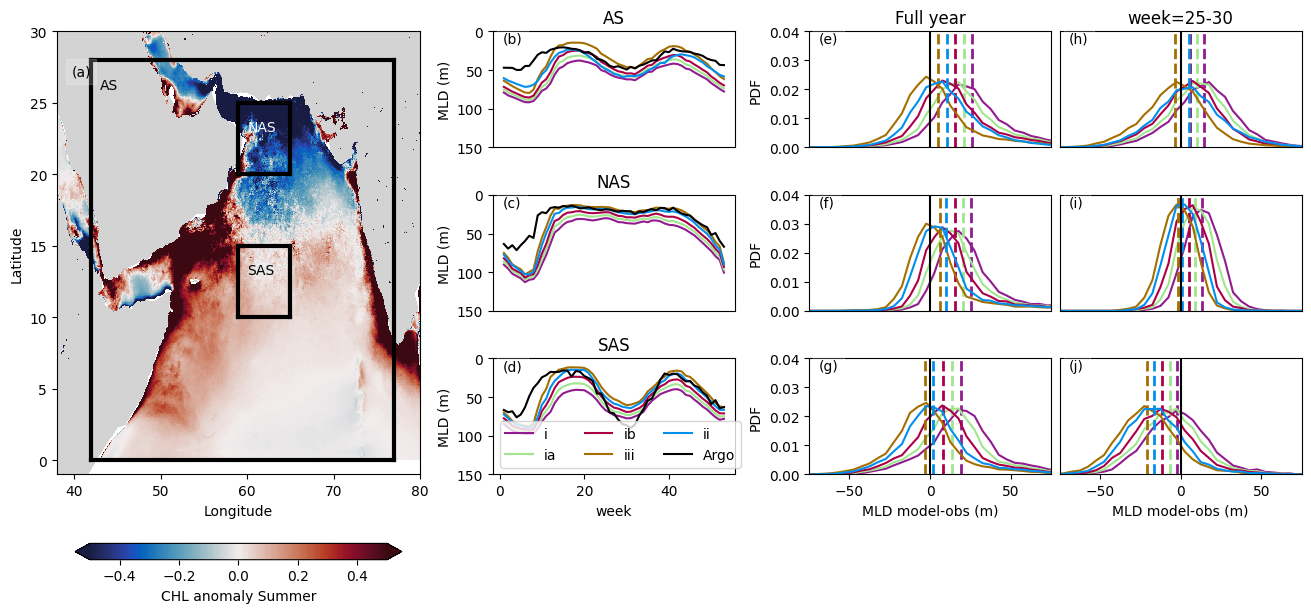

In [16]:
from matplotlib.gridspec import GridSpec
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


fig=plt.figure(figsize=(13,6), constrained_layout=True)
xx,yy=3,9
gs = GridSpec(xx,yy, figure=fig)

ax = fig.add_subplot(gs[:3, :3])
t=ax.text(x=.04,y=.9,s="(" + letters[0] + ')',transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=0.2, edgecolor='w'))
ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2024_n35.0_s-10.0_w25.0_e85.0.nc')

ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='lightgray')
# plt.pcolormesh(mean_summer.longitude, mean_summer.latitude,mean_summer, cmap=cmo.algae, vmin=0, vmax=0.5)

cb=ax.pcolormesh(mean_summer.longitude, mean_summer.latitude, mean_summer-yearmean, cmap=cmo.balance, vmin=-0.5, vmax=0.5)
cb=plt.colorbar(cb, extend='both', orientation='horizontal', shrink=0.9)
cb.set_label('CHL anomaly Summer')



ax.plot([lonn[29],lonn[29]], [latt[25],latt[30]], c='k', lw=3)
ax.plot([lonn[29],lonn[35]], [latt[25],latt[25]],  c='k', lw=3)
ax.plot([lonn[29],lonn[35]], [latt[30],latt[30]],  c='k', lw=3)
ax.plot([lonn[35],lonn[35]], [latt[25],latt[30]],  c='k', lw=3)
ax.text(60, 23, 'NAS', c='w')

ax.plot([lonn[29],lonn[29]], [latt[15],latt[20]], c='k', lw=3)
ax.plot([lonn[29],lonn[35]], [latt[15],latt[15]],  c='k', lw=3)
ax.plot([lonn[29],lonn[35]], [latt[20],latt[20]],  c='k', lw=3)
ax.plot([lonn[35],lonn[35]], [latt[15],latt[20]],  c='k', lw=3)
ax.text(60, 13, 'SAS')


ax.plot([lonn[12],lonn[12]], [latt[5],latt[33]], c='k', lw=3)
ax.plot([lonn[12],lonn[47]], [latt[5],latt[5]],  c='k', lw=3)
ax.plot([lonn[47],lonn[47]], [latt[5],latt[33]],  c='k', lw=3)
ax.plot([lonn[12],lonn[47]], [latt[33],latt[33]],  c='k', lw=3)
ax.text(43, 26, 'AS')


ax.set_ylim(-1,30)
ax.set_xlim(38,80)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# from matplotlib.gridspec import GridSpec
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.5


cl=["#911b8f",
"#a1e58e",
"#ab0046",
"#a46f00", "#018fee"]
lab=['i', 'ia', 'ib', 'iii', 'ii' ]

lats=slice(5,33), slice(25,30), slice(15,20)
lons=slice(12,47), slice(29,35), slice(29,35)
tids=slice(0,10), slice(25,35)
tit=['AS', 'NAS', 'SAS']


for i in range(3):
    ax = fig.add_subplot(gs[i:i+1, 3:3+2])
    
    # ax=plt.subplot(331+3*i)
    t=ax.text(x=.04,y=.9,s="(" + letters[i+1] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=0.2, edgecolor='w'))

    plt.title(tit[i])
    lat, lon=lats[i], lons[i]
    plt.ylim(150,0)
    if i==2:
        plt.xlabel('week')
    if i<2:
        plt.xticks([])
    for i in range(5):
        plt.plot(grid_week_configs[0].week , grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).mixed_layer_depth.mean('latitude_bins').mean('longitude_bins'),color=cl[i],  label=lab[i])
    plt.plot(df_grid_mld_f_week.week, df_grid_mld_f_week.sel(latitude_f_bins=lat, longitude_f_bins=lon).mean('latitude_f_bins').mean('longitude_f_bins'), c='k', label='Argo')
        # df_grid_mld_f_week.sel(latitude_f_bins=lat, longitude_f_bins=lon).std('latitude_f_bins').std('longitude_f_bins').plot(c='k')
    plt.ylabel('MLD (m)')
plt.legend(ncol=3)


for i in range(3):
    ax = fig.add_subplot(gs[i:i+1, 5:5+2])
    
    t=ax.text(x=.04,y=.9,s="(" + letters[i+1+3] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=0.2, edgecolor='w'))

    lat, lon=lats[i], lons[i]
    if i ==0:
        plt.title('Full year')
    if i<2:
        plt.xticks([])
    if i==2:
        plt.xlabel('MLD model-obs (m)')
        
    for i in range(5):
        N, _, _=plt.hist((grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).mixed_layer_depth.values-df_grid_mld_f_week.sel(latitude_f_bins=lat, longitude_f_bins=lon).values).flatten(), 
                         bins=np.arange(-100,100,5), density=True, color=cl[i], alpha=0)
        plt.plot(np.arange(-100,100,5)[:-1]+5/2, pd.DataFrame(N).rolling(5, center=True).mean()[0], color=cl[i], alpha=1)
        
        # plt.fill_between(np.arange(-100,100,5)[:-1]+5/2,np.zeros(len(pd.DataFrame(N).rolling(5, center=True).mean().to_numpy())), pd.DataFrame(N).rolling(5, center=True).mean()[0], color=cl[i], alpha=0.3)
        plt.axvline(np.nanmean(grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).mixed_layer_depth.values-df_grid_mld_f_week.sel(latitude_f_bins=lat, longitude_f_bins=lon).values).flatten(), c=cl[i],lw=2,ls='--', label=lab[i])
        # plt.axvline(np.nanmedian(grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).mixed_layer_depth.values-df_grid_mld_f_week.sel(latitude_f_bins=lat, longitude_f_bins=lon).values).flatten(), c=cl[i], ls=':', alpha=0.5)
    plt.ylabel('PDF')

    plt.axvline(0, c='k')
    # plt.plot([10,100], [10,100])
    plt.xlim(-75,75)
    plt.ylim(0,0.04)
    
    # plt.ylim(10,120)
    # plt.ylabel('obs')

for i in range(3):
    ax = fig.add_subplot(gs[i:i+1, 7:])
    
    t=ax.text(x=.04,y=.9,s="(" + letters[i+1+6] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=0.2, edgecolor='w'))

    lat, lon=lats[i], lons[i]
    tid=tids[1]
    if i ==0:
        plt.title('week=25-30')
    if i<2:
        plt.xticks([])
    if i==2:
        plt.xlabel('MLD model-obs (m)')
    # plt.ylabel('obs')
    for i in range(5):
        N, _, _=plt.hist((grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).sel(week=tid).mixed_layer_depth.values-df_grid_mld_f_week.sel(week=tid).sel(latitude_f_bins=lat, longitude_f_bins=lon).values).flatten(),
                 bins=np.arange(-100,100,5), density=True, color=cl[i], fill=False, alpha=0)
        plt.plot(np.arange(-100,100,5)[:-1]+5/2, pd.DataFrame(N).rolling(5, center=True).mean()[0], color=cl[i], alpha=1)

        # plt.fill_between(np.arange(-100,100,5)[:-1]+5/2,np.zeros(len(pd.DataFrame(N).rolling(5, center=True).mean().to_numpy())), pd.DataFrame(N).rolling(5, center=True).mean()[0], color=cl[i], alpha=0.3)
        plt.axvline(np.nanmean(grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).sel(week=tid).mixed_layer_depth.values-df_grid_mld_f_week.sel(week=tid).sel(latitude_f_bins=lat, longitude_f_bins=lon).values).flatten(),lw=2, ls='--', c=cl[i], label=lab[i])
        # plt.axvline(np.nanmedian(grid_week_configs[i].sel(latitude_bins=lat, longitude_bins=lon).sel(week=tid).mixed_layer_depth.values-df_grid_mld_f_week.sel(week=tid).sel(latitude_f_bins=lat, longitude_f_bins=lon).values).flatten(), c=cl[i], ls=':', alpha=0.5)
    plt.ylim(0,0.04)
    plt.axvline(0, c='k')
    # plt.plot([10,100], [10,100])
    plt.xlim(-75,75)
    plt.yticks([])
    # plt.ylim(10,120)
    
plt.savefig('Figures/SFigure_SAS_watertype.png', dpi=600, bbox_inches='tight')    

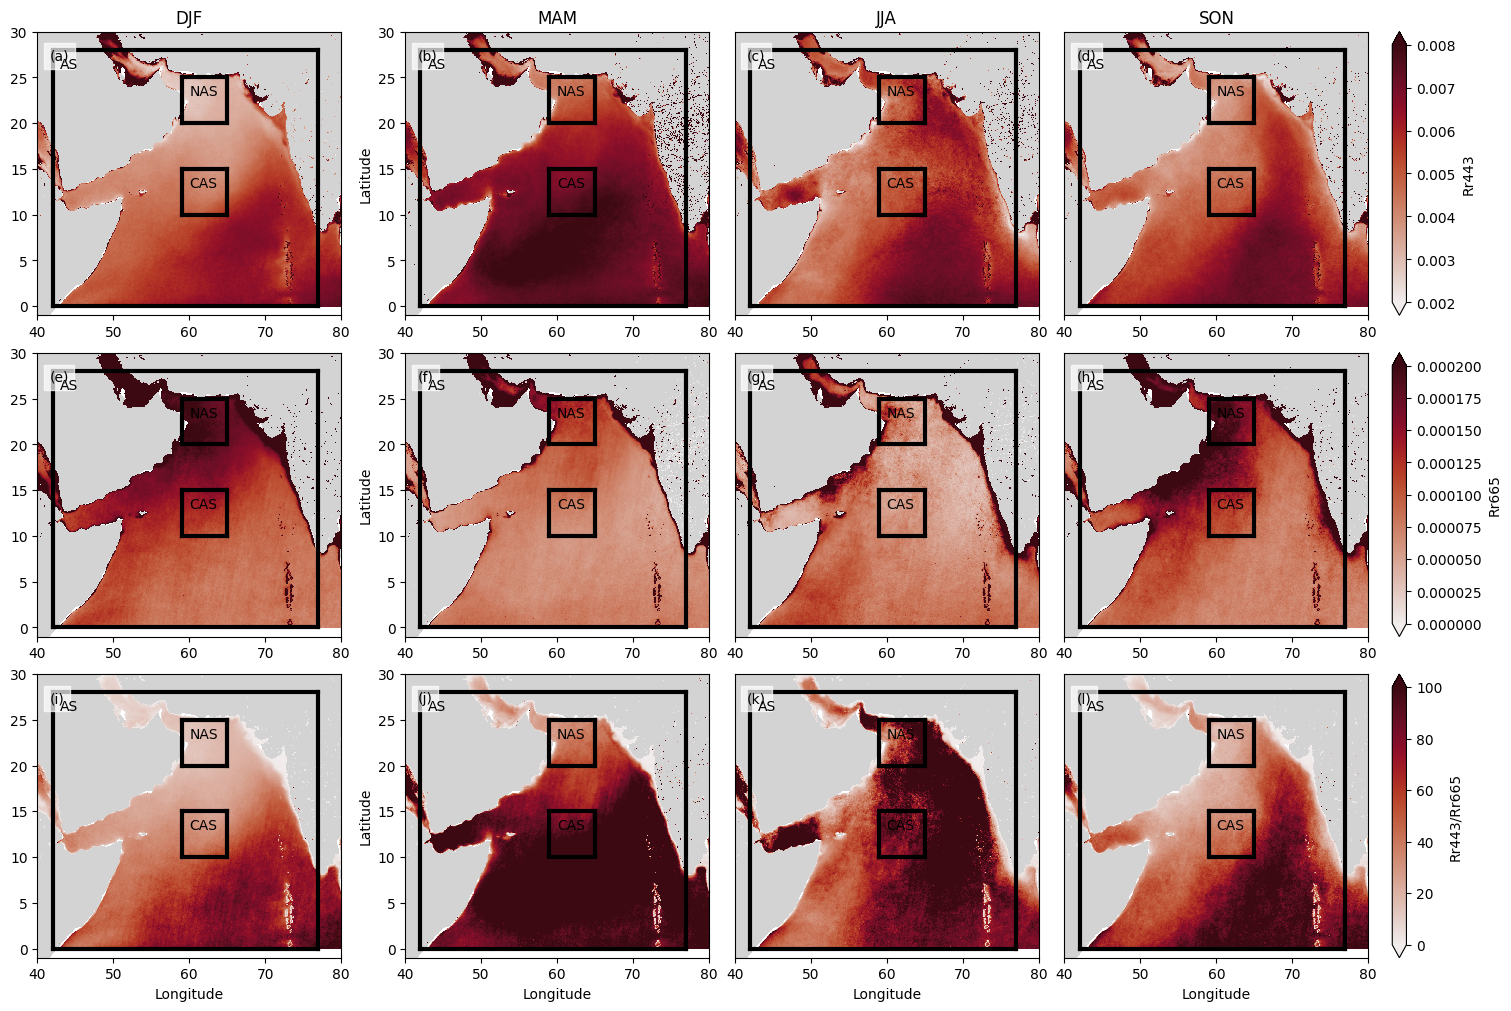

In [41]:
from matplotlib.gridspec import GridSpec
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
alp=0.7
ds_bath=xr.open_dataset('/home/jupyter-estelfont/scratch/estel/datasets/bathymetry/gebco_2024_n35.0_s-10.0_w25.0_e85.0.nc')


fig=plt.figure(figsize=(15,10), constrained_layout=True)
xx,yy=3,4
gs = GridSpec(xx,yy, figure=fig)

dss=df_ratio_443.groupby('time.season').mean()
sea=['DJF','MAM', 'JJA', 'SON']
for i in range(4):
    ax = fig.add_subplot(gs[0:1, i:i+1])
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    ax.set_title(sea[i])

    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='lightgray')
    # plt.pcolormesh(mean_summer.longitude, mean_summer.latitude,mean_summer, cmap=cmo.algae, vmin=0, vmax=0.5)
    dff_=dss.sel(season=sea[i])
    cb=ax.pcolormesh(dff_.lon, dff_.lat, dff_.Rrs_443, cmap=cmo.amp, vmin=0.002, vmax=0.008)
    
    ax.plot([lonn[29],lonn[29]], [latt[25],latt[30]], c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[25],latt[25]],  c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[30],latt[30]],  c='k', lw=3)
    ax.plot([lonn[35],lonn[35]], [latt[25],latt[30]],  c='k', lw=3)
    ax.text(60, 23, 'NAS')

    ax.plot([lonn[29],lonn[29]], [latt[15],latt[20]], c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[15],latt[15]],  c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[20],latt[20]],  c='k', lw=3)
    ax.plot([lonn[35],lonn[35]], [latt[15],latt[20]],  c='k', lw=3)
    ax.text(60, 13, 'CAS')


    ax.plot([lonn[12],lonn[12]], [latt[5],latt[33]], c='k', lw=3)
    ax.plot([lonn[12],lonn[47]], [latt[5],latt[5]],  c='k', lw=3)
    ax.plot([lonn[47],lonn[47]], [latt[5],latt[33]],  c='k', lw=3)
    ax.plot([lonn[12],lonn[47]], [latt[33],latt[33]],  c='k', lw=3)
    ax.text(43, 26, 'AS')


    ax.set_ylim(-1,30)
    ax.set_xlim(40,80)
    # ax.set_xlabel('Longitude')
    if i==1:
        ax.set_ylabel('Latitude')
    if i>1:
        ax.set_yticks([])

cb=plt.colorbar(cb, extend='both')
cb.set_label('Rr443')



dss=df_ratio_665.groupby('time.season').mean()
sea=['DJF','MAM', 'JJA', 'SON']
for i in range(4):
    ax = fig.add_subplot(gs[1:2, i:i+1])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+4] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='lightgray')
    # plt.pcolormesh(mean_summer.longitude, mean_summer.latitude,mean_summer, cmap=cmo.algae, vmin=0, vmax=0.5)
    dff_=dss.sel(season=sea[i])
    cb=ax.pcolormesh(dff_.lon, dff_.lat, dff_.Rrs_665, cmap=cmo.amp, vmin=0, vmax=0.0002)
    
    ax.plot([lonn[29],lonn[29]], [latt[25],latt[30]], c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[25],latt[25]],  c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[30],latt[30]],  c='k', lw=3)
    ax.plot([lonn[35],lonn[35]], [latt[25],latt[30]],  c='k', lw=3)
    ax.text(60, 23, 'NAS')

    ax.plot([lonn[29],lonn[29]], [latt[15],latt[20]], c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[15],latt[15]],  c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[20],latt[20]],  c='k', lw=3)
    ax.plot([lonn[35],lonn[35]], [latt[15],latt[20]],  c='k', lw=3)
    ax.text(60, 13, 'SAS')


    ax.plot([lonn[12],lonn[12]], [latt[5],latt[33]], c='k', lw=3)
    ax.plot([lonn[12],lonn[47]], [latt[5],latt[5]],  c='k', lw=3)
    ax.plot([lonn[47],lonn[47]], [latt[5],latt[33]],  c='k', lw=3)
    ax.plot([lonn[12],lonn[47]], [latt[33],latt[33]],  c='k', lw=3)
    ax.text(43, 26, 'AS')


    ax.set_ylim(-1,30)
    ax.set_xlim(40,80)
    # ax.set_xlabel('Longitude')
    if i==1:
        ax.set_ylabel('Latitude')
    if i>1:
        ax.set_yticks([])

cb=plt.colorbar(cb, extend='both')
cb.set_label('Rr665')


dss1=df_ratio_443.groupby('time.season').mean()
dss2=df_ratio_665.groupby('time.season').mean()
dss=dss1.Rrs_443/dss2.Rrs_665
sea=['DJF','MAM', 'JJA', 'SON']
for i in range(4):
    ax = fig.add_subplot(gs[2:3, i:i+1])
    t=ax.text(x=.04,y=.9,s="(" + letters[i+8] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))
    ax.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='lightgray')
    # plt.pcolormesh(mean_summer.longitude, mean_summer.latitude,mean_summer, cmap=cmo.algae, vmin=0, vmax=0.5)
    dff_=dss.sel(season=sea[i])
    cb=ax.pcolormesh(dff_.lon, dff_.lat, dff_, cmap=cmo.amp, vmin=0, vmax=100)
    
    ax.plot([lonn[29],lonn[29]], [latt[25],latt[30]], c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[25],latt[25]],  c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[30],latt[30]],  c='k', lw=3)
    ax.plot([lonn[35],lonn[35]], [latt[25],latt[30]],  c='k', lw=3)
    ax.text(60, 23, 'NAS')

    ax.plot([lonn[29],lonn[29]], [latt[15],latt[20]], c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[15],latt[15]],  c='k', lw=3)
    ax.plot([lonn[29],lonn[35]], [latt[20],latt[20]],  c='k', lw=3)
    ax.plot([lonn[35],lonn[35]], [latt[15],latt[20]],  c='k', lw=3)
    ax.text(60, 13, 'SAS')


    ax.plot([lonn[12],lonn[12]], [latt[5],latt[33]], c='k', lw=3)
    ax.plot([lonn[12],lonn[47]], [latt[5],latt[5]],  c='k', lw=3)
    ax.plot([lonn[47],lonn[47]], [latt[5],latt[33]],  c='k', lw=3)
    ax.plot([lonn[12],lonn[47]], [latt[33],latt[33]],  c='k', lw=3)
    ax.text(43, 26, 'AS')


    ax.set_ylim(-1,30)
    ax.set_xlim(40,80)
    ax.set_xlabel('Longitude')
    if i==1:
        ax.set_ylabel('Latitude')
    if i>1:
        ax.set_yticks([])

cb=plt.colorbar(cb, extend='both')
cb.set_label('Rr443/Rr665')

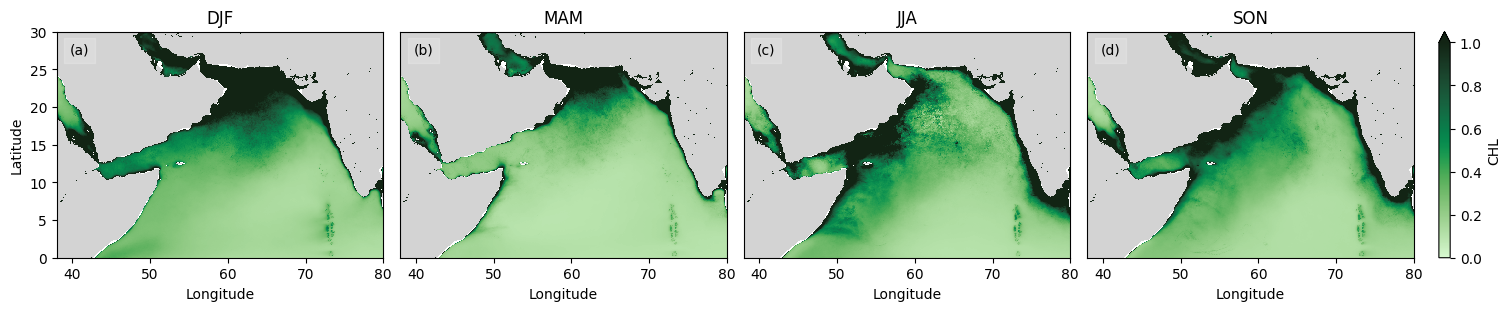

In [416]:
plt.figure(figsize=(15,3), constrained_layout=True)
seas=[mean_wint, mean_spr, mean_summer, mean_fall]
sea=['DJF','MAM', 'JJA', 'SON']
for i in range(4):
    ax=plt.subplot(141+i)
    
    t=ax.text(x=.04,y=.9,s="(" + letters[i] + ')',transform=ax.transAxes)
    t.set_bbox(dict(facecolor='w', alpha=0.2, edgecolor='w'))

    plt.title(sea[i])
    plt.contourf(ds_bath.lon[::200],ds_bath.lat[::200], ds_bath.elevation[::200, ::200],  levels=[-1,3000], colors='lightgray')
    cb=ax.pcolormesh(yearmean.longitude, yearmean.latitude,seas[i], cmap=cmo.algae, vmin=0, vmax=1)
    if i ==0:
        ax.set_ylabel('Latitude')    # cb=ax.pcolormesh(mean_summer.longitude, mean_summer.latitude, mean_summer.CHL-yearmean.CHL, cmap=cmo.balance, vmin=-0.5, vmax=0.5)
    if i>0:
        ax.set_yticks([])
    ax.set_ylim(0,30)
    ax.set_xlim(38,80)
    ax.set_xlabel('Longitude')
    
    if i==3:
        cb=plt.colorbar(cb, extend='max')
        cb.set_label('CHL')
  

R² Value: 0.23528217181620537
Slope: 0.47844942375380795, Intercept: 44.18838056072762
R² Value: 0.24860867997746583
Slope: 0.5058426719346069, Intercept: 38.071409318401834
R² Value: 0.2643060845016396
Slope: 0.5404679336980286, Intercept: 31.424754316910697
R² Value: 0.2827245262252327
Slope: 0.5888705013971094, Intercept: 23.21518592439081
R² Value: 0.2924981540928193
Slope: 0.6093560354529164, Intercept: 17.73606215375329


(0.0, 200.0)

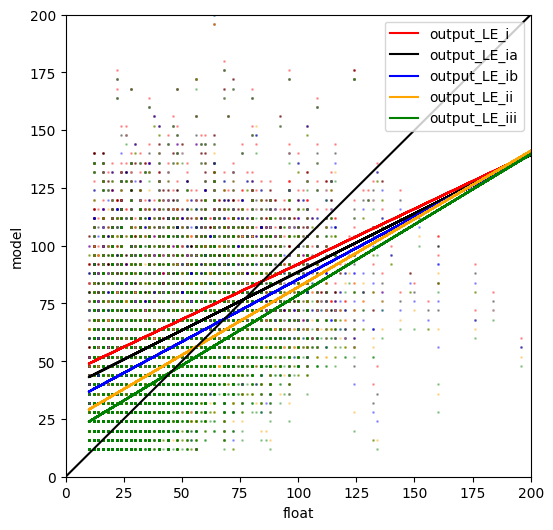

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.figure(figsize=(6,6))

clrs=['r', 'k', 'b', 'orange', 'green']

for i in range(len(grid_week_configs)):
    
    X, Y=df_grid_mld_week_float.values.flatten(),  (np.round(grid_week_configs[i].mixed_layer_depth.values.flatten()/ 4) * 4)
    X[X<10]=np.nan
    # X[X>100]=np.nan
    Y[Y<10]=np.nan
    # Y[Y>100]=np.nan
    mask = ~np.isnan(X).flatten() & ~np.isnan(Y)
    X_clean = X[mask].reshape(-1, 1)
    Y_clean = Y[mask]
    # Create a linear regression model
    model = LinearRegression()
    model.fit(X_clean, Y_clean)

    # Predict values for X to plot the regression line
    Y_pred = model.predict(X_clean)
    
    r2 = r2_score(Y_clean, Y_pred)
    print(f'R² Value: {r2}')
    
    # Get the slope (coefficient)
    slope = model.coef_
    intercept = model.intercept_
    
    print(f'Slope: {slope[0]}, Intercept: {intercept}')
    # Plotting the data points
    plt.scatter(X_clean, Y_clean, color=clrs[i], s=1, alpha=0.3)

    # Plotting the regression line
    plt.plot(X_clean, Y_pred, color=clrs[i], label=configs[i])
    
    
#     X, Y=df_grid_mld_week_float.values.flatten(),  grid_week_configs[i].mixed_layer_depth.values.flatten()
#     X[X<10]=np.nan
#     X[X>100]=np.nan
    
#     mask = ~np.isnan(X).flatten() & ~np.isnan(Y)
#     X_clean = X[mask].reshape(-1, 1)
#     Y_clean = Y[mask]
#     # Create a linear regression model
#     model = LinearRegression()
#     model.fit(X_clean, Y_clean)

#     # Predict values for X to plot the regression line
#     Y_pred = model.predict(X_clean)

#     # Plotting the data points
#     plt.scatter(X_clean, Y_clean, color=clrs[i], s=1, alpha=0.3)

#     # Plotting the regression line
#     plt.plot(X_clean, Y_pred, color=clrs[i], label=configs[i])


plt.xlabel('float')
plt.ylabel('model')
plt.legend()
plt.plot([0,200],[0,200], c='k')
plt.xlim(0,200)
X[X<10]=np.nan
plt.ylim(0, 200)

DJF
output_LE_i
R² Value: 0.036457590174522436
Slope: 0.1605851778025251, Intercept: 75.41063086816563
output_LE_ia
R² Value: 0.0411047324483893
Slope: 0.17490379301764614, Intercept: 70.75652979593804
output_LE_ib
R² Value: 0.04869878171861608
Slope: 0.19719798263847438, Intercept: 65.55646394766362
output_LE_ii
R² Value: 0.05047522804366589
Slope: 0.21369667122351899, Intercept: 60.30836080847168
output_LE_iii
R² Value: 0.057072280079759286
Slope: 0.2418375012421011, Intercept: 54.9973522603801
MAM
output_LE_i
R² Value: 0.09377359124091511
Slope: 0.5532992130524964, Intercept: 38.37541266782327
output_LE_ia
R² Value: 0.09829593297777639
Slope: 0.5731589050503118, Intercept: 30.798909829512926
output_LE_ib
R² Value: 0.10747207625874744
Slope: 0.6057200405704439, Intercept: 22.481282906478036
output_LE_ii
R² Value: 0.12470920229278526
Slope: 0.658333279937946, Intercept: 11.928325172633565
output_LE_iii
R² Value: 0.14128939679504304
Slope: 0.6659594604628513, Intercept: 6.2762276573282

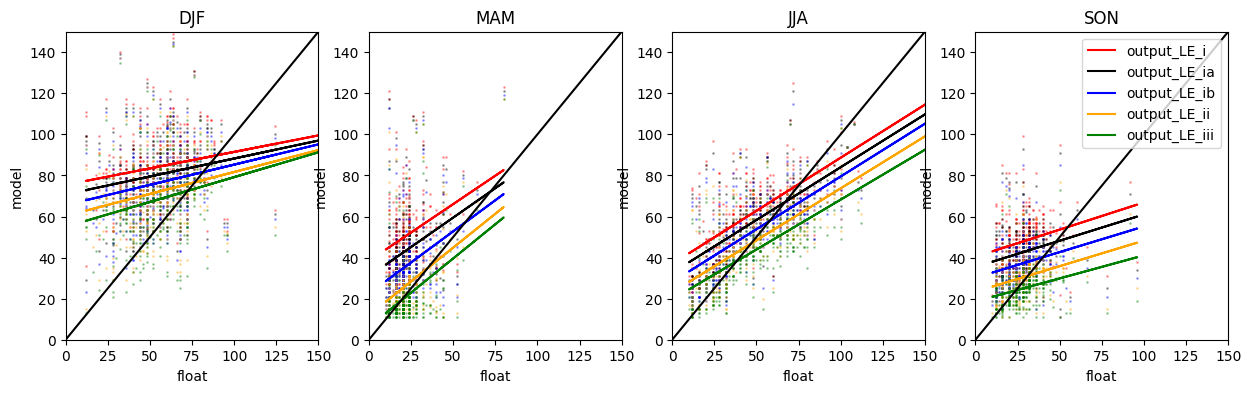

In [100]:
plt.figure(figsize=(15,4))

clrs=['r', 'k', 'b', 'orange', 'green']
seasons_=['DJF', 'MAM', 'JJA', 'SON']
s=0

for seas in seasons_:
    plt.subplot(141+s)
    s=s+1
    print(seas)
    plt.title(seas)
    for i in range(len(grid_season_configs)):
        print(configs[i])
        # X, Y=df_grid_mld_season_float.sel(season=seas).values.flatten(),  (np.round(grid_season_configs[i].sel(season=seas).mixed_layer_depth.values.flatten()/ 4) * 4)
        X, Y=df_grid_mld_season_float.sel(season=seas).values.flatten(),  grid_season_configs[i].sel(season=seas).mixed_layer_depth.values.flatten()
        
        X[X<10]=np.nan
        # X[X>100]=np.nan
        Y[Y<10]=np.nan
        # Y[Y>100]=np.nan
        mask = ~np.isnan(X).flatten() & ~np.isnan(Y)
        X_clean = X[mask].reshape(-1, 1)
        Y_clean = Y[mask]
        # Create a linear regression model
        model = LinearRegression()
        model.fit(X_clean, Y_clean)

        # Predict values for X to plot the regression line
        Y_pred = model.predict(X_clean)

        r2 = r2_score(Y_clean, Y_pred)
        print(f'R² Value: {r2}')

        # Get the slope (coefficient)
        slope = model.coef_
        intercept = model.intercept_

        print(f'Slope: {slope[0]}, Intercept: {intercept}')
        # Plotting the data points
        plt.scatter(X_clean, Y_clean, color=clrs[i], s=1, alpha=0.3)

        # Plotting the regression line
        plt.plot(X_clean, Y_pred, color=clrs[i], label=configs[i])

    plt.xlabel('float')
    plt.ylabel('model')
    plt.plot([0,150],[0,150], c='k')
    plt.xlim(0,150)
    # X[X<10]=np.nan
    plt.ylim(0, 150)
    
plt.legend()